🟢 EDA BEFORE PREPROCESSING

Shape: (100, 7)

Data Types:
 Customer_ID            object
Age                     int64
Annual_Income         float64
Policy_Count            int64
Total_Premium_Paid    float64
Claim_Frequency         int64
Policy_Upgrades         int64
dtype: object

Missing Values:
 Customer_ID           0
Age                   0
Annual_Income         0
Policy_Count          0
Total_Premium_Paid    0
Claim_Frequency       0
Policy_Upgrades       0
dtype: int64


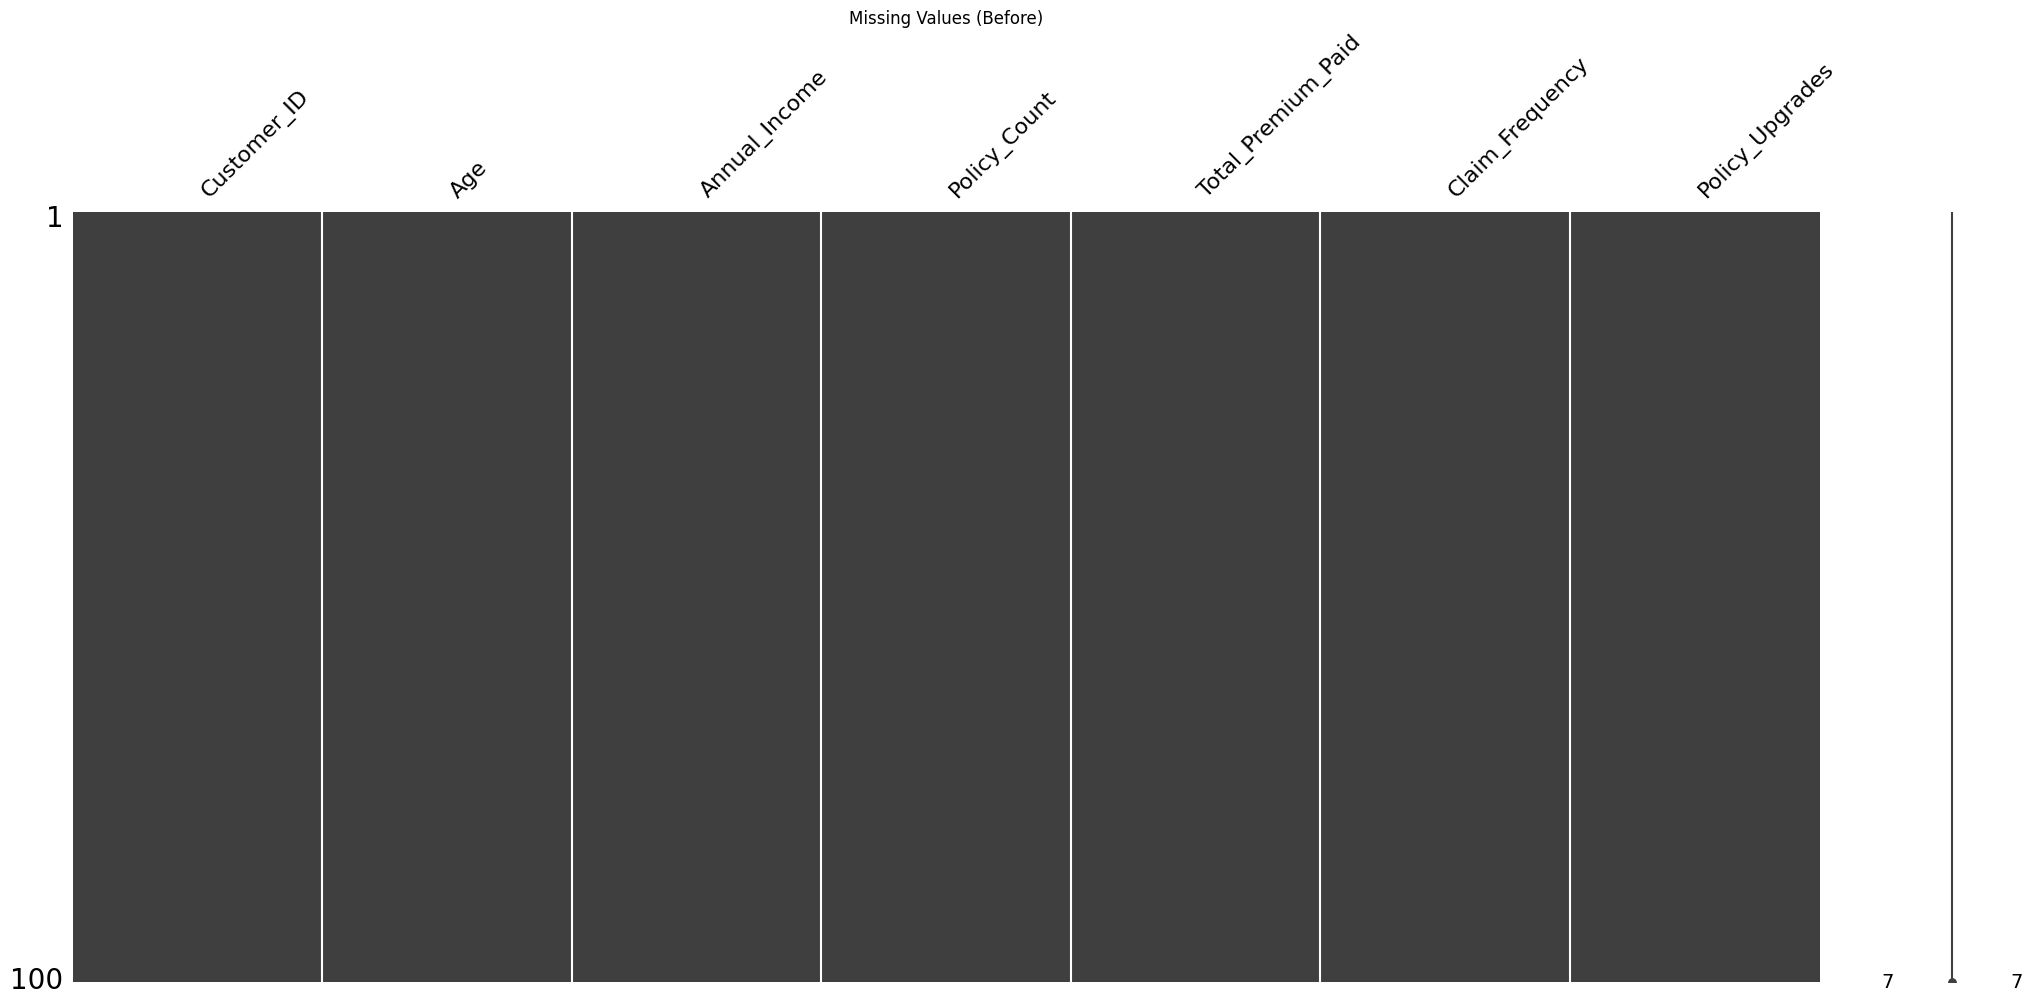

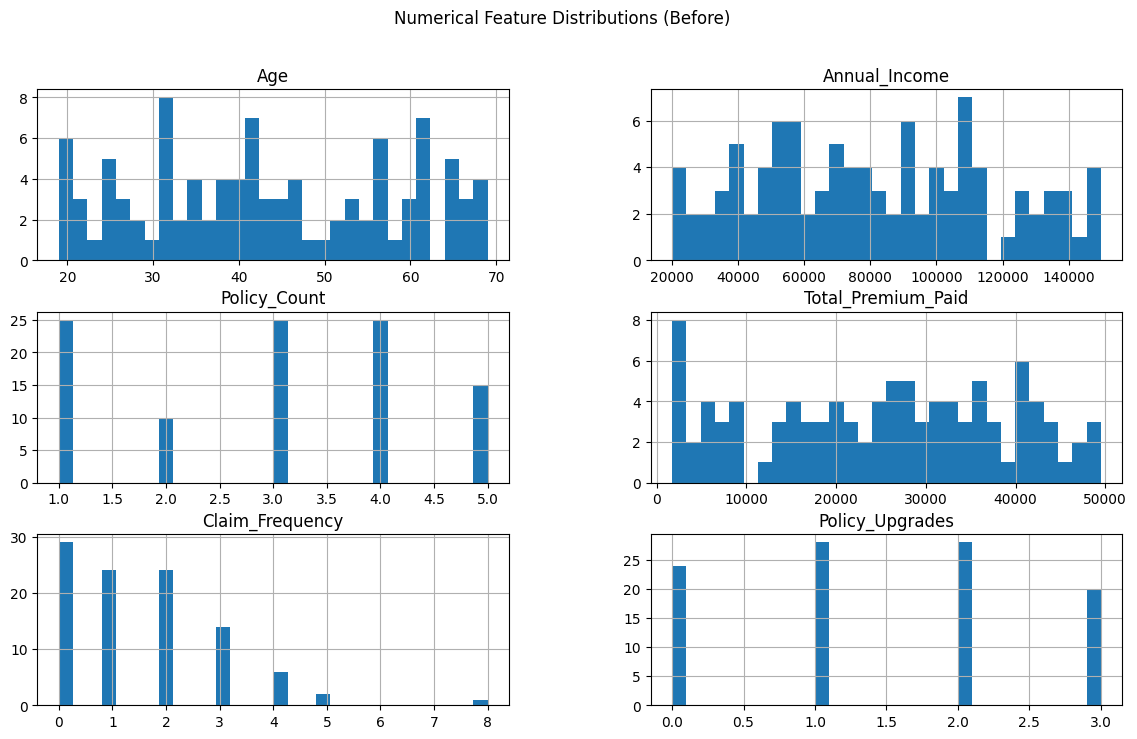

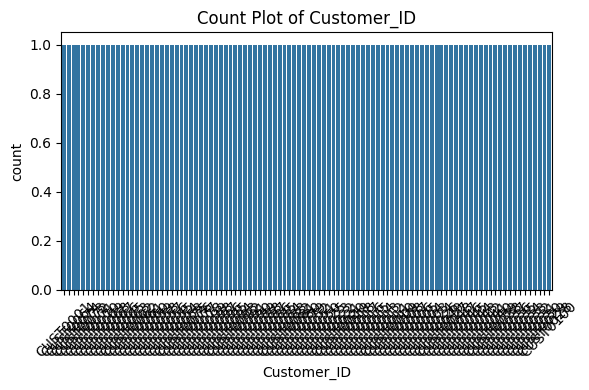


🛠️ PREPROCESSING...

✅ Preprocessing Complete
New Shape: (100, 105)

🟢 EDA AFTER PREPROCESSING

Missing Values After: 0


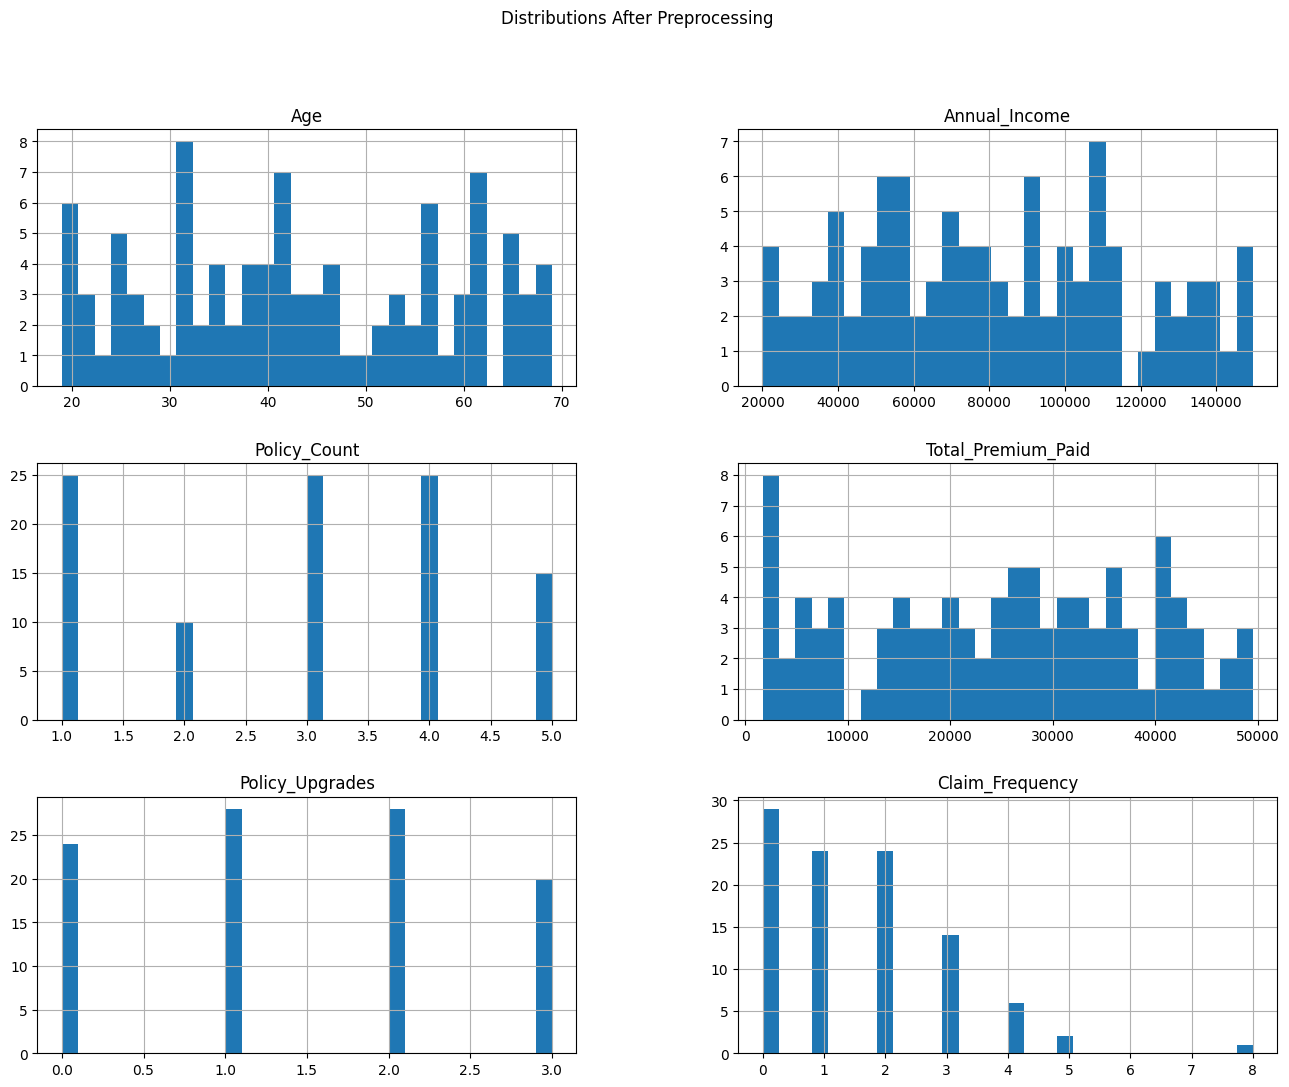

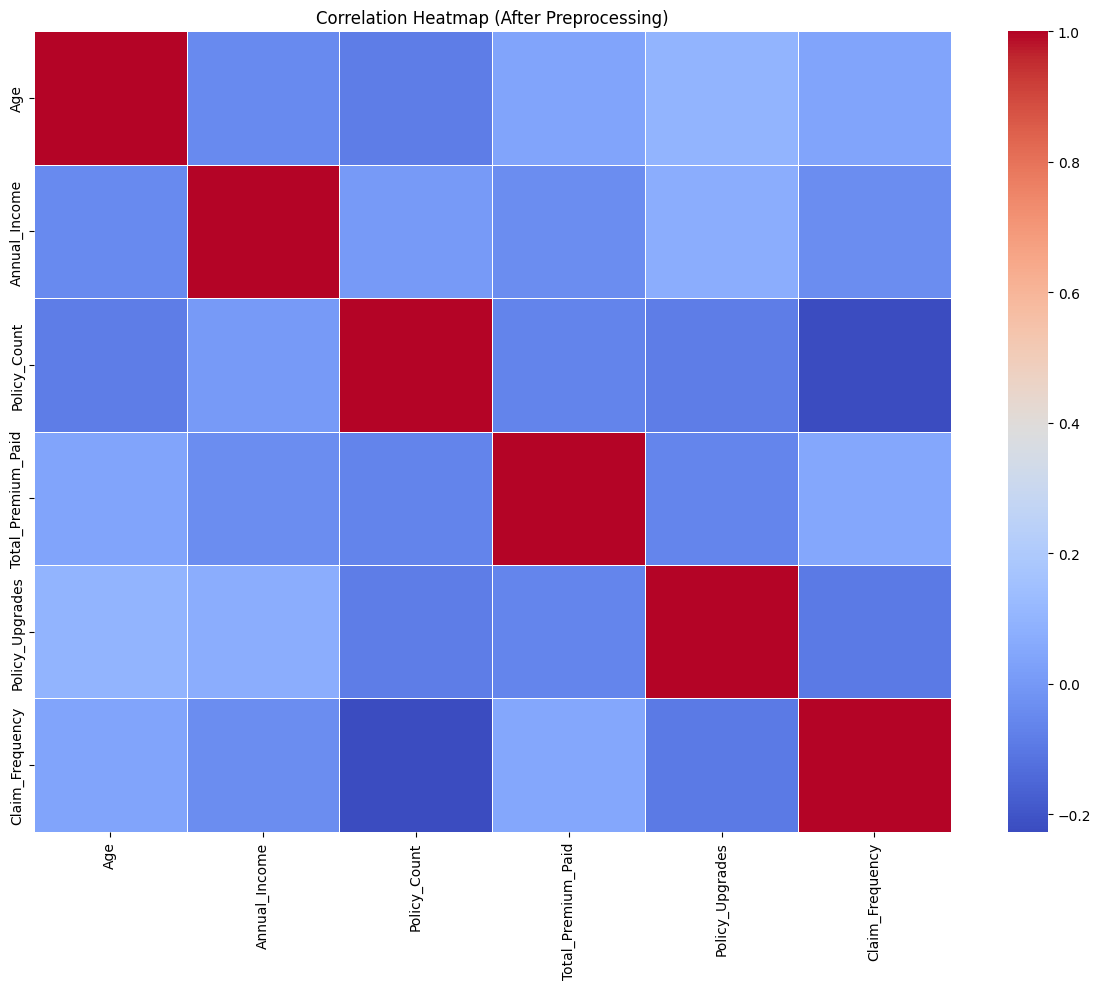


Summary Stats:


,Age,Annual_Income,Policy_Count,Total_Premium_Paid,Policy_Upgrades,Claim_Frequency
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,43.350000,81135.332800,2.950000,25029.108000,1.440000,1.560000
std,14.904663,35484.691046,1.402559,13735.261815,1.066667,1.465564
min,19.000000,20067.650000,1.000000,1705.280000,0.000000,0.000000
25%,31.750000,52004.497500,1.750000,14605.265000,1.000000,0.000000
50%,42.000000,78320.200000,3.000000,26348.435000,1.000000,1.000000
75%,57.000000,108872.952500,4.000000,35613.230000,2.000000,2.000000
max,69.000000,149706.260000,5.000000,49512.640000,3.000000,8.000000



Data Types After Preprocessing:
Age                       int64
Annual_Income           float64
Policy_Count              int64
Total_Premium_Paid      float64
Policy_Upgrades           int64
                         ...   
Customer_ID_CUST0097       bool
Customer_ID_CUST0098       bool
Customer_ID_CUST0099       bool
Customer_ID_CUST0100       bool
Claim_Frequency           int64
Length: 105, dtype: object


In [2]:
# 📦 Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder

# ✅ Define the EDA + Preprocessing Function
def run_eda_pipeline(df, target_column=None, encode_method='onehot', drop_first=True):
    
    df = df.copy()
    
    # ✅ Check if target column exists
    if target_column and target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in DataFrame. Available columns: {df.columns.tolist()}")

    print("🟢 EDA BEFORE PREPROCESSING\n")
    print("Shape:", df.shape)
    print("\nData Types:\n", df.dtypes)
    print("\nMissing Values:\n", df.isnull().sum())

    # 📊 Missing Values Visual
    msno.matrix(df)
    plt.title("Missing Values (Before)")
    plt.show()

    # 📈 Distribution Plots
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[num_cols].hist(figsize=(14, 8), bins=30)
    plt.suptitle("Numerical Feature Distributions (Before)")
    plt.show()

    # 📉 Count Plots for Categorical Features
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    if target_column and target_column in cat_cols:
        cat_cols.remove(target_column)

    for col in cat_cols:
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=col, order=df[col].value_counts().index)
        plt.title(f"Count Plot of {col}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    # -------------------------
    # 🧹 Preprocessing
    # -------------------------
    print("\n🛠️ PREPROCESSING...\n")
    df.drop_duplicates(inplace=True)

    # Fill missing values
    df.fillna(df.median(numeric_only=True), inplace=True)
    df.fillna(df.mode().iloc[0], inplace=True)

    # Encode Categorical
    df_processed = df.copy()

    if encode_method == 'onehot':
        if target_column:
            df_features = df_processed.drop(columns=[target_column])
            df_encoded = pd.get_dummies(df_features, drop_first=drop_first)
            df_processed = pd.concat([df_encoded, df[[target_column]]], axis=1)
        else:
            df_processed = pd.get_dummies(df_processed, drop_first=drop_first)

    elif encode_method == 'label':
        label_enc = LabelEncoder()
        for col in df_processed.select_dtypes(include='object').columns:
            if col != target_column:
                df_processed[col] = label_enc.fit_transform(df_processed[col])
    else:
        raise ValueError("encode_method must be 'onehot' or 'label'")

    # 🎯 Encode target column if categorical
    if target_column and df[target_column].dtype == 'object':
        df_processed[target_column] = LabelEncoder().fit_transform(df_processed[target_column])

    print("✅ Preprocessing Complete")
    print("New Shape:", df_processed.shape)

    # -------------------------
    # EDA After Preprocessing
    # -------------------------
    print("\n🟢 EDA AFTER PREPROCESSING\n")
    print("Missing Values After:", df_processed.isnull().sum().sum())

    df_processed.hist(figsize=(16, 12), bins=30)
    plt.suptitle("Distributions After Preprocessing")
    plt.show()

    # 🧊 Correlation Matrix Only for Numeric Columns
    numeric_df = df_processed.select_dtypes(include=[np.number])
    plt.figure(figsize=(12, 10))
    sns.heatmap(numeric_df.corr(), cmap="coolwarm", linewidths=0.5)
    plt.title("Correlation Heatmap (After Preprocessing)")
    plt.tight_layout()
    plt.show()

    print("\nSummary Stats:")
    display(df_processed.describe())

     # ✅ Data types after preprocessing
    print("\nData Types After Preprocessing:")
    print(df_processed.dtypes)
    
    return df_processed

df = pd.read_csv("C:/Users/Administrator/customer_segmentation_dataset.csv")
processed_df = run_eda_pipeline(df, target_column='Claim_Frequency', encode_method='onehot')

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances
import joblib
import logging
from datetime import datetime

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def train_segmentation_model():
    try:
        # 1. Load and validate data
        data_path = "C:/Users/Administrator/customer_segmentation_dataset.csv"
        logging.info(f"Loading dataset from {data_path}")
        df = pd.read_csv(data_path)
        
        # Validate required columns
        required_columns = {
            'Age', 'Annual_Income', 'Policy_Count',
            'Total_Premium_Paid', 'Claim_Frequency', 'Policy_Upgrades'
        }
        if not required_columns.issubset(df.columns):
            missing = required_columns - set(df.columns)
            raise ValueError(f"Missing required columns: {missing}")

        # 2. Feature selection and preprocessing
        features = list(required_columns)
        X = df[features]
        
        # 3. Data scaling
        logging.info("Scaling features")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # 4. Dimensionality reduction
        logging.info("Applying PCA")
        pca = PCA(n_components=2)  # Fixed for visualization
        X_pca = pca.fit_transform(X_scaled)

        # 5. Optimized clustering
        logging.info("Training K-Means model")
        kmeans = KMeans(
            n_clusters=3,
            init='k-means++',
            n_init=50,
            max_iter=500,
            tol=1e-04,
            random_state=42
        )
        kmeans.fit(X_pca)

        # 6. Model evaluation
        silhouette_avg = silhouette_score(X_pca, kmeans.labels_)
        logging.info(f"Silhouette Score: {silhouette_avg:.3f}")

        # 7. Create output directory
        model_dir = "C:/Users/Administrator/models"
        os.makedirs(model_dir, exist_ok=True)

        # 8. Versioned model saving
        version = "v2"
        model_files = {
            'scaler': scaler,
            'pca': pca,
            'kmeans': kmeans
        }

        logging.info("Saving core models")
        for name, model in model_files.items():
            filename = f"{model_dir}/{name}_{version}.joblib"
            joblib.dump(model, filename, compress=3)
            logging.info(f"Saved {filename}")

        # 9. Save cluster labels
        cluster_labels = {
            0: "Young Budget Policyholders",
            1: "Prime Coverage Users",
            2: "High-Risk Claimers"
        }
        joblib.dump(cluster_labels, f"{model_dir}/cluster_labels_{version}.joblib")

        # 10. Save metadata
        metadata = {
            'features': features,
            'creation_date': datetime.now().strftime("%Y-%m-%d"),
            'silhouette_score': silhouette_avg,
            'model_version': version
        }
        joblib.dump(metadata, f"{model_dir}/metadata_{version}.joblib")

        logging.info("Training completed successfully")
        return True

    except Exception as e:
        logging.error(f"Training failed: {str(e)}")
        return False

if __name__ == "__main__":
    train_segmentation_model()

2025-05-02 22:35:11,224 - INFO - Loading dataset from C:/Users/Administrator/customer_segmentation_dataset.csv
2025-05-02 22:35:11,234 - INFO - Scaling features
2025-05-02 22:35:11,262 - INFO - Applying PCA
2025-05-02 22:35:11,280 - INFO - Training K-Means model
2025-05-02 22:35:11,563 - INFO - Silhouette Score: 0.398
2025-05-02 22:35:11,563 - INFO - Saving core models
2025-05-02 22:35:11,583 - INFO - Saved C:/Users/Administrator/models/scaler_v2.joblib
2025-05-02 22:35:11,608 - INFO - Saved C:/Users/Administrator/models/pca_v2.joblib
2025-05-02 22:35:11,635 - INFO - Saved C:/Users/Administrator/models/kmeans_v2.joblib
2025-05-02 22:35:11,673 - INFO - Training completed successfully


In [9]:
import pickle
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Example model objects — replace with your trained models
with open("C:/Users/Administrator/models/customer_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("C:/Users/Administrator/models/pca.pkl", "wb") as f:
    pickle.dump(pca, f)

with open("C:/Users/Administrator/models/kmeans.pkl", "wb") as f:
    pickle.dump(kmeans, f)

with open("C:/Users/Administrator/models/cluster_labels.pkl", "wb") as f:
    pickle.dump(cluster_labels, f)
